In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 33.6 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 209 kB 67.3 MB/s 
     |████████████████████████████████| 78 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 146 kB 8.1 MB/s 
     |████████████████████████████████| 112 kB 15.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=acc70ca840bf953c90ad8a05877160b676696c233a26c3c18fc9e84d66383b66
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import joblib
import pickle
import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

In [48]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_v1.pickle', 'rb') as f:
    data = pickle.load(f)


data = data[['date', 'trade_price']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date').reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['trade_price']
training_data = scaler.fit_transform(data[scale_cols])


In [49]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    
    for i in range(len(data) - seq_length - 1):
        _x = data[i: (i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def get_data_loader(data, seq_length, train_batch_size, test_batch_size):

    x, y = sliding_windows(data, seq_length)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

    train_ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    train_dl = DataLoader(train_ds, batch_size = train_batch_size)

    test_ds = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
    test_dl = DataLoader(test_ds, batch_size = test_batch_size)

    input_size = x_train.shape[-1]

    return train_dl, test_dl, input_size, x_train, x_test, y_train, y_test

In [50]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size , num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [51]:
def train(log_interval, model, train_dl, optimizer, criterion, epoch):
    model.train()
    for epoch in range(epoch):
        best_loss = np.inf
        for data, target in train_dl:
            output = model(data)
            optimizer.zero_grad()
            loss = criterion(output, target) # mean-squared error for regression
            loss.backward()
            optimizer.step()
            best_loss = min(loss, best_loss)

        if ( epoch % log_interval == 0 ):
            print(f'Epoch: {epoch}, loss: {loss.item()}')

    return best_loss


def test_predict(model, test_dl):
    model.eval()
    pred = []
    with torch.no_grad():
        for data, target in test_dl:
            train_predict = model(data)
            pred.extend(train_predict.data.numpy().squeeze()) 

    return pred


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [54]:
def objective(trial):

    cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'train_batch_size' : trial.suggest_categorical('train_batch_size',[64, 128, 256]), # [64, 128, 256]
            'test_batch_size' : trial.suggest_categorical('test_batch_size',[64, 128, 256]),  # [64, 128, 256]
            'num_epochs' : trial.suggest_int('num_epochs', 1000, 1600, 100), 
            'save_model' : False,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), #trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), # learning rate을 0.01-0.1까지 로그 uniform 분포로 사용          
            'momentum': trial.suggest_uniform('momentum', 0.4, 0.99),
            'optimizer': trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]), # trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]),
            # 'activation': trial.suggest_categorical('activation',[ torch.nn.relu6, torch.nn.tanh ]),
            'hidden_size': trial.suggest_categorical('hidden_size',[64, 128, 256]),
            'num_layers': trial.suggest_int('num_layers', 1, 1),
            'num_classes': trial.suggest_int('num_classes', 1, 1),
            'seed': 42,
            'log_interval' : 100 }

    torch.manual_seed(cfg['seed'])

    train_dl, test_dl, input_size, x_train, x_test, y_train, y_test = get_data_loader(training_data, 20, cfg['train_batch_size'], cfg['test_batch_size'])
    model = LSTM(num_classes=cfg['num_classes'], input_size=input_size, hidden_size=cfg['hidden_size'], num_layers=cfg['num_layers'])
    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['learning_rate'])
    criterion = torch.nn.MSELoss()

    train(cfg['log_interval'], model, train_dl, optimizer, criterion, cfg['num_epochs'])

    if cfg['save_model']:
        loss = torch.save(model.state_dict(), "lstm.pt")

    pred = test_predict(model, test_dl)

    predict = scaler.inverse_transform(np.expand_dims(pred, axis = 1))
    actual = scaler.inverse_transform(y_test)

    SMAPE = smape(actual, predict)
    print(f' \nSMAPE : {SMAPE}')


    return SMAPE


In [55]:
sampler = optuna.samplers.TPESampler()
#   sampler = optuna.samplers.SkoptSampler()
    
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=10) 
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna.pkl')

[I 2022-06-03 15:37:44,052] A new study created in memory with name: no-name-4f132dc4-fc96-426c-bb52-c1f7f5239ec7


Epoch: 0, loss: 7.3063788414001465
Epoch: 100, loss: 0.10927562415599823
Epoch: 200, loss: 0.009324967861175537
Epoch: 300, loss: 0.0062406049109995365
Epoch: 400, loss: 0.050177741795778275
Epoch: 500, loss: 0.0038951202295720577
Epoch: 600, loss: 0.05295033007860184
Epoch: 700, loss: 0.004019015934318304
Epoch: 800, loss: 0.010643166489899158
Epoch: 900, loss: 0.0030488029588013887
Epoch: 1000, loss: 0.010697533376514912
Epoch: 1100, loss: 0.006811410654336214
Epoch: 1200, loss: 0.00442957878112793


[I 2022-06-03 15:54:59,179] Trial 0 finished with value: 4.6048375586483665 and parameters: {'train_batch_size': 128, 'test_batch_size': 128, 'num_epochs': 1300, 'learning_rate': 0.029056535644501474, 'momentum': 0.6284175248497864, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 0 with value: 4.6048375586483665.


 
SMAPE : 4.6048375586483665
Epoch: 0, loss: 0.04025416821241379
Epoch: 100, loss: 0.0015008532209321856
Epoch: 200, loss: 0.0010564436670392752
Epoch: 300, loss: 0.018223538994789124
Epoch: 400, loss: 0.005460611544549465
Epoch: 500, loss: 0.004880777094513178
Epoch: 600, loss: 0.0048246365040540695
Epoch: 700, loss: 0.0048158434219658375
Epoch: 800, loss: 0.00481399055570364
Epoch: 900, loss: 0.004813884384930134


[I 2022-06-03 16:00:34,069] Trial 1 finished with value: 43.080967267660554 and parameters: {'train_batch_size': 64, 'test_batch_size': 256, 'num_epochs': 1000, 'learning_rate': 0.09544694495195773, 'momentum': 0.5975335100304541, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 0 with value: 4.6048375586483665.


 
SMAPE : 43.080967267660554
Epoch: 0, loss: 0.2443445771932602
Epoch: 100, loss: 0.0044528343714773655
Epoch: 200, loss: 0.003668662393465638
Epoch: 300, loss: 0.0036170976236462593
Epoch: 400, loss: 0.0035679424181580544
Epoch: 500, loss: 0.003521154634654522
Epoch: 600, loss: 0.003476544748991728
Epoch: 700, loss: 0.003433945821598172
Epoch: 800, loss: 0.0033932009246200323
Epoch: 900, loss: 0.0033541833981871605
Epoch: 1000, loss: 0.003316772636026144
Epoch: 1100, loss: 0.0032808587420731783
Epoch: 1200, loss: 0.003246342996135354
Epoch: 1300, loss: 0.0032131338957697153
Epoch: 1400, loss: 0.0031811490189284086


[I 2022-06-03 16:03:25,544] Trial 2 finished with value: 4.219964754130744 and parameters: {'train_batch_size': 128, 'test_batch_size': 128, 'num_epochs': 1500, 'learning_rate': 0.04318377801716521, 'momentum': 0.5148862686700492, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 2 with value: 4.219964754130744.


 
SMAPE : 4.219964754130744
Epoch: 0, loss: 0.27720388770103455
Epoch: 100, loss: 0.00355058372952044
Epoch: 200, loss: 0.0034679058007895947
Epoch: 300, loss: 0.003391328500583768
Epoch: 400, loss: 0.0033205251675099134
Epoch: 500, loss: 0.0032548082526773214
Epoch: 600, loss: 0.003193599171936512
Epoch: 700, loss: 0.0031364045571535826
Epoch: 800, loss: 0.003082799259573221
Epoch: 900, loss: 0.0030324163381010294
Epoch: 1000, loss: 0.002984941005706787
Epoch: 1100, loss: 0.0029400959610939026
Epoch: 1200, loss: 0.002897638827562332


[I 2022-06-03 16:08:47,192] Trial 3 finished with value: 3.9426004865181663 and parameters: {'train_batch_size': 256, 'test_batch_size': 128, 'num_epochs': 1300, 'learning_rate': 0.09651793488945436, 'momentum': 0.9644939807620974, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 128, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 3.9426004865181663
Epoch: 0, loss: 0.04277828335762024
Epoch: 100, loss: 0.0022147444542497396
Epoch: 200, loss: 0.002149293664842844
Epoch: 300, loss: 0.0020768800750374794
Epoch: 400, loss: 0.0020121317356824875
Epoch: 500, loss: 0.001953830709680915
Epoch: 600, loss: 0.0019010029500350356
Epoch: 700, loss: 0.00185286661144346
Epoch: 800, loss: 0.001808780012652278
Epoch: 900, loss: 0.0017682170728221536
Epoch: 1000, loss: 0.001730735064484179


[I 2022-06-03 16:13:54,863] Trial 4 finished with value: 4.848232511615727 and parameters: {'train_batch_size': 64, 'test_batch_size': 128, 'num_epochs': 1100, 'learning_rate': 0.05648382695325936, 'momentum': 0.6408410834938058, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 128, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 4.848232511615727
Epoch: 0, loss: 0.25500422716140747
Epoch: 100, loss: 0.07047786563634872
Epoch: 200, loss: 0.004377775359898806
Epoch: 300, loss: 0.0036988279316574335
Epoch: 400, loss: 0.003672240534797311
Epoch: 500, loss: 0.003644094569608569
Epoch: 600, loss: 0.003616650588810444
Epoch: 700, loss: 0.003589940257370472
Epoch: 800, loss: 0.0035639344714581966
Epoch: 900, loss: 0.003538599004969001
Epoch: 1000, loss: 0.0035139047540724277
Epoch: 1100, loss: 0.0034898254089057446
Epoch: 1200, loss: 0.003466336987912655
Epoch: 1300, loss: 0.003443414345383644
Epoch: 1400, loss: 0.0034210369922220707


[I 2022-06-03 16:16:22,757] Trial 5 finished with value: 4.386735003626525 and parameters: {'train_batch_size': 256, 'test_batch_size': 64, 'num_epochs': 1500, 'learning_rate': 0.02618311752400224, 'momentum': 0.5430102009368402, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 4.386735003626525
Epoch: 0, loss: 0.4165182113647461
Epoch: 100, loss: 0.0018820103723555803
Epoch: 200, loss: 0.005372088868170977
Epoch: 300, loss: 0.0019038550090044737
Epoch: 400, loss: 0.007361996918916702
Epoch: 500, loss: 0.007360584568232298
Epoch: 600, loss: 0.2761906087398529
Epoch: 700, loss: 0.004659221973270178
Epoch: 800, loss: 0.0019829648081213236
Epoch: 900, loss: 0.008108439855277538
Epoch: 1000, loss: 0.008180027827620506
Epoch: 1100, loss: 0.00219161668792367
Epoch: 1200, loss: 0.0091490363702178


[I 2022-06-03 16:21:30,177] Trial 6 finished with value: 4.264164709380126 and parameters: {'train_batch_size': 128, 'test_batch_size': 256, 'num_epochs': 1300, 'learning_rate': 0.041621242092425924, 'momentum': 0.9504929202580219, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 128, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 4.264164709380126
Epoch: 0, loss: 0.1235685721039772
Epoch: 100, loss: 0.0033755816984921694
Epoch: 200, loss: 0.004748394712805748
Epoch: 300, loss: 0.0009079903247766197
Epoch: 400, loss: 0.0007557001663371921
Epoch: 500, loss: 0.000761830189730972
Epoch: 600, loss: 0.0008819550275802612
Epoch: 700, loss: 0.0029381755739450455
Epoch: 800, loss: 0.004279153887182474
Epoch: 900, loss: 0.0010886579984799027


[I 2022-06-03 16:24:08,305] Trial 7 finished with value: 5.433244020851454 and parameters: {'train_batch_size': 64, 'test_batch_size': 256, 'num_epochs': 1000, 'learning_rate': 0.0377138265957939, 'momentum': 0.5556436846493761, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 5.433244020851454
Epoch: 0, loss: 0.2930919826030731
Epoch: 100, loss: 0.007712381426244974
Epoch: 200, loss: 0.003505995497107506
Epoch: 300, loss: 0.0034648908767849207
Epoch: 400, loss: 0.003424892434850335
Epoch: 500, loss: 0.0033865587320178747
Epoch: 600, loss: 0.0033497854601591825
Epoch: 700, loss: 0.003314471570774913
Epoch: 800, loss: 0.003280526027083397
Epoch: 900, loss: 0.003247863845899701
Epoch: 1000, loss: 0.0032164081931114197
Epoch: 1100, loss: 0.0031860913150012493
Epoch: 1200, loss: 0.003156845225021243
Epoch: 1300, loss: 0.0031286091543734074
Epoch: 1400, loss: 0.0031013262923806906


[I 2022-06-03 16:41:59,438] Trial 8 finished with value: 3.987561095704218 and parameters: {'train_batch_size': 256, 'test_batch_size': 256, 'num_epochs': 1500, 'learning_rate': 0.049083366712477934, 'momentum': 0.7050805968143137, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 3.987561095704218
Epoch: 0, loss: 3.8823752403259277
Epoch: 100, loss: 0.032505638897418976
Epoch: 200, loss: 0.02128574252128601
Epoch: 300, loss: 0.08175276219844818
Epoch: 400, loss: 0.4749211370944977
Epoch: 500, loss: 0.47933635115623474
Epoch: 600, loss: 0.5630046725273132
Epoch: 700, loss: 0.17063835263252258
Epoch: 800, loss: 0.007591023109853268
Epoch: 900, loss: 0.03850965574383736


[I 2022-06-03 18:31:35,426] Trial 9 finished with value: 30.42770658300465 and parameters: {'train_batch_size': 64, 'test_batch_size': 64, 'num_epochs': 1000, 'learning_rate': 0.09924809937879647, 'momentum': 0.4469208396202139, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 3 with value: 3.9426004865181663.


 
SMAPE : 30.42770658300465


['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna.pkl']

In [56]:
study.best_params

{'hidden_size': 128,
 'learning_rate': 0.09651793488945436,
 'momentum': 0.9644939807620974,
 'num_classes': 1,
 'num_epochs': 1300,
 'num_layers': 1,
 'optimizer': torch.optim.sgd.SGD,
 'test_batch_size': 128,
 'train_batch_size': 256}

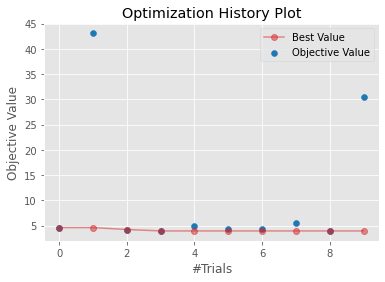

In [57]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [58]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value:  3.9426004865181663
  Params: 
    train_batch_size: 256
    test_batch_size: 128
    num_epochs: 1300
    learning_rate: 0.09651793488945436
    momentum: 0.9644939807620974
    optimizer: <class 'torch.optim.sgd.SGD'>
    hidden_size: 128
    num_layers: 1
    num_classes: 1


## Plot Results

In [59]:
train_dl, test_dl, input_size, x_train, x_test, y_train, y_test = get_data_loader(training_data, 20, study.best_params['train_batch_size'], study.best_params['test_batch_size'])
best_model = LSTM(num_classes=study.best_params['num_classes'], input_size=input_size, hidden_size=study.best_params['hidden_size'], num_layers=study.best_params['num_layers'])
optimizer = study.best_params['optimizer'](best_model.parameters(), lr=study.best_params['learning_rate'])
criterion = torch.nn.MSELoss()

train(10, best_model, train_dl, optimizer, criterion, study.best_params['num_epochs'])

pred = test_predict(best_model, test_dl)

predicted_for_plot = scaler.inverse_transform(np.concatenate((y_train, np.expand_dims(pred, axis = 1))))
actual_for_plot = scaler.inverse_transform(np.concatenate((y_train, y_test)))

SMAPE = smape(actual_for_plot, predicted_for_plot)
print(f' \nSMAPE : {SMAPE}')

plt.plot(predicted_for_plot[len(y_test):])
plt.plot(actual_for_plot[len(y_test):])
plt.suptitle('Timeseries Prediction')
plt.axvline(x = y_train.shape[0] - len(y_test), c = 'r', linestyle = '--')
plt.show()



KeyError: ignored